# Congestion charges

Is there a way we can proxy for congestion, and find out what hours of the day are more prone to congestion? 

We take a proxy by considering the NYC speed limit of 25mph (although, it is slower in certain sections), taking the time taken to travel the *Euclidean distance*, and then finding out the excess time each trip takes is. Of course, this will be quite variant, as cars don't travel in straight lines from point A to point B, but the hope is that across a wide enough data set, the mean response shows a trend in congestion.

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### The feature

For two geographic points given by `(latitude, longitude)`, we can find the distance between the two in miles (or kilometres) by using the Harversine formula.
From this, the sub-feature we are creating simply divides the distance given by the Harversine formula by 0.007 (25 mph in miles/second), to get the time taken to drive the Euclidean distance. 
Then, our feature is the difference between the trip time and the euclidean distance time; or:

    `congestion = trip time - euclidean time`

In [31]:
from math import radians, cos, sin, asin, sqrt

def get_congestion(row):
    # Taken from https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    def haversine(lon1, lat1, lon2, lat2):
        """
        Calculate the great circle distance in kilometers between two points 
        on the earth (specified in decimal degrees)
        """
        # convert decimal degrees to radians 
        lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

        # haversine formula 
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a)) 
        r = 3956 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
        return c * r
    
    miles_per_second = 0.007
    euclidean_dist = haversine(row['pickup_longitude'], row['pickup_latitude'], row['dropoff_longitude'], row['dropoff_latitude'])
    euclidean_trip_time = euclidean_dist / miles_per_second

    return row['trip_time_in_secs'] - euclidean_trip_time

Now our gathering of locations is not *perfect* - the geolocator is not an extremely precise tool, and has misinterpreted some places as being out of New York City entirely. So we will ignore any data points with `congestion < 0`, as these will not be helpful for our analysis.

#### An example

In [34]:
example_data = pd.read_parquet('../data/tr_data/2009-01.parquet')

In [48]:
example_data['congestion'] = example_data.apply(get_congestion, axis=1)
congestion_data = example_data[example_data['congestion'] > 0].copy()

Text(0.5, 1.0, 'Distribution of congestion times')

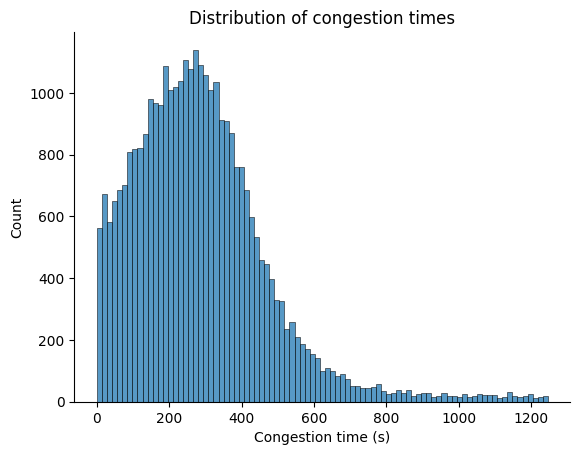

In [65]:
sns.histplot(congestion_data['congestion'])
sns.despine()
plt.xlabel('Congestion time (s)')
plt.title('Distribution of congestion times')

Grouping by time of the day, we can consider when congestion times are the longest.

Text(0.5, 1.0, 'Mean congestion times across the day')

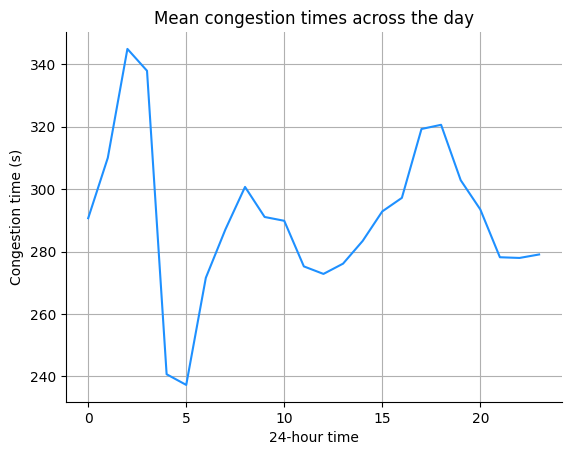

In [66]:
congestion_data['hour'] = congestion_data['pickup_datetime'].dt.hour
hour_by_congestion = congestion_data.groupby('hour')['congestion'].mean()

plt.plot(hour_by_congestion.index, hour_by_congestion, color='dodgerblue')
sns.despine()
plt.grid()
plt.xlabel('24-hour time')
plt.ylabel('Congestion time (s)')
plt.title('Mean congestion times across the day')